# Kaggle Tabular Playground Series - Sep 2022 #

## Using XGBoost for Regression to Forecast Sales Data ##

### Introduction ###

The task for this competition is to forecast sales data for two competing merchanise stores in six countries for four different products. We are also asked to forecast sales during the tumultuous year 2021, when conditions are far from the ordinary.

A complete description of the task, as well as the datasets, can be found at this link: https://www.kaggle.com/competitions/tabular-playground-series-sep-2022

### Outline of Project ###

We'll frame this problem as a supervised learning task and apply XGBoost for regression.

A brief outline of the project is as follows:

#### Data ####

1) Exploratory Data Analysis

2) Labelling & Organizing Data

3) Defining Baseline
#### Modelling ####

4) Training Model

5) Error Analysis

#### Up Next? ####

6) Time Series Analysis

### 1) Exploratory Data Analysis ###

Let's import the relevant packages we will be using, and look at the data set first.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import plot_importance, plot_tree

In [2]:
sales = pd.read_csv('/Users/admin/Downloads/tabular-playground-series-sep-2022/train.csv', 
                    index_col = [0], parse_dates=[1])
#Alternatively, without parse_dates, we can convert date column into datetime object manually
#sales['date'] = sales['date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      70128 non-null  datetime64[ns]
 1   country   70128 non-null  object        
 2   store     70128 non-null  object        
 3   product   70128 non-null  object        
 4   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.2+ MB


In [3]:
print('The first five rows of the dataset are:')
print('\n')
sales.head()

The first five rows of the dataset are:




,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


We do not have any missing values in any of the 5 columns. 

The dates have been parsed and converted to datetime objects, and num_sold contains integers.

The 'country', 'store' and 'product' columns contain strings that we'll have to convert into categorical variables subsequently.

Let's also do a quick check on the distribution of these three columns to see if our data is skewed in any way.

In [4]:
#Checking the distribution of values for our categorical variables
print('The two stores are:')
print('\n')
print(sales['store'].value_counts())
print('\n')
print('Our two stores operate in the following countries:')
print('\n')
print(sales['country'].value_counts())
print('\n')
print('The two stores sell the following products:')
print('\n')
print(sales['product'].value_counts())

The two stores are:


KaggleRama    35064
KaggleMart    35064
Name: store, dtype: int64


Our two stores operate in the following countries:


France     11688
Italy      11688
Belgium    11688
Poland     11688
Germany    11688
Spain      11688
Name: country, dtype: int64


The two stores sell the following products:


Kaggle Getting Started              17532
Kaggle for Kids: One Smart Goose    17532
Kaggle Recipe Book                  17532
Kaggle Advanced Techniques          17532
Name: product, dtype: int64


The dataset is not skewed in any way, and there is a even distribution across the different categorical variables.

In [5]:
sales['num_sold'].describe()

count    70128.000000
mean       194.296986
std        126.893874
min         19.000000
25%         95.000000
50%        148.000000
75%        283.000000
max        986.000000
Name: num_sold, dtype: float64

We have got a high standard deviation, so some time-series features will be necessary. The delta between the min. and max. value is 967, whereas the mean is 194. We need to separate the Sold Units by weekday to get a better insight into the data

To have an overview, let's visualize the sales data over the time period (2017 - 2021) first without accounting for the other categorical variables

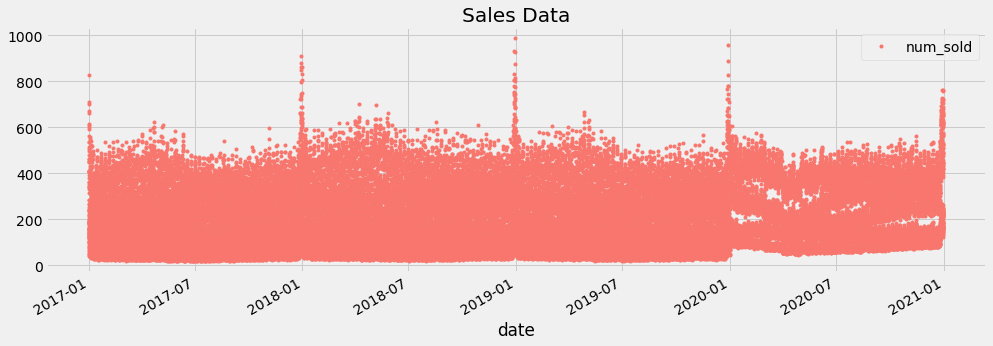

In [6]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = sales[['date','num_sold']].plot(x='date',y='num_sold',style='.', figsize=(15,5), color=color_pal[0], title='Sales Data')

The plot above shows that there are certain spikes in sales, possibly due to events such as holidays or sale events. 

However, there are too many data points which overlap, and we can't get much more information from this. 

Let's decompose the sales data by store, country and product to have a clearer picture.

We'll draw the plots for the two stores separately to avoid cluttering the screen too much.

In [7]:
stores = list(sales['store'].unique())
countries = list(sales['country'].unique())
products = list(sales['product'].unique())

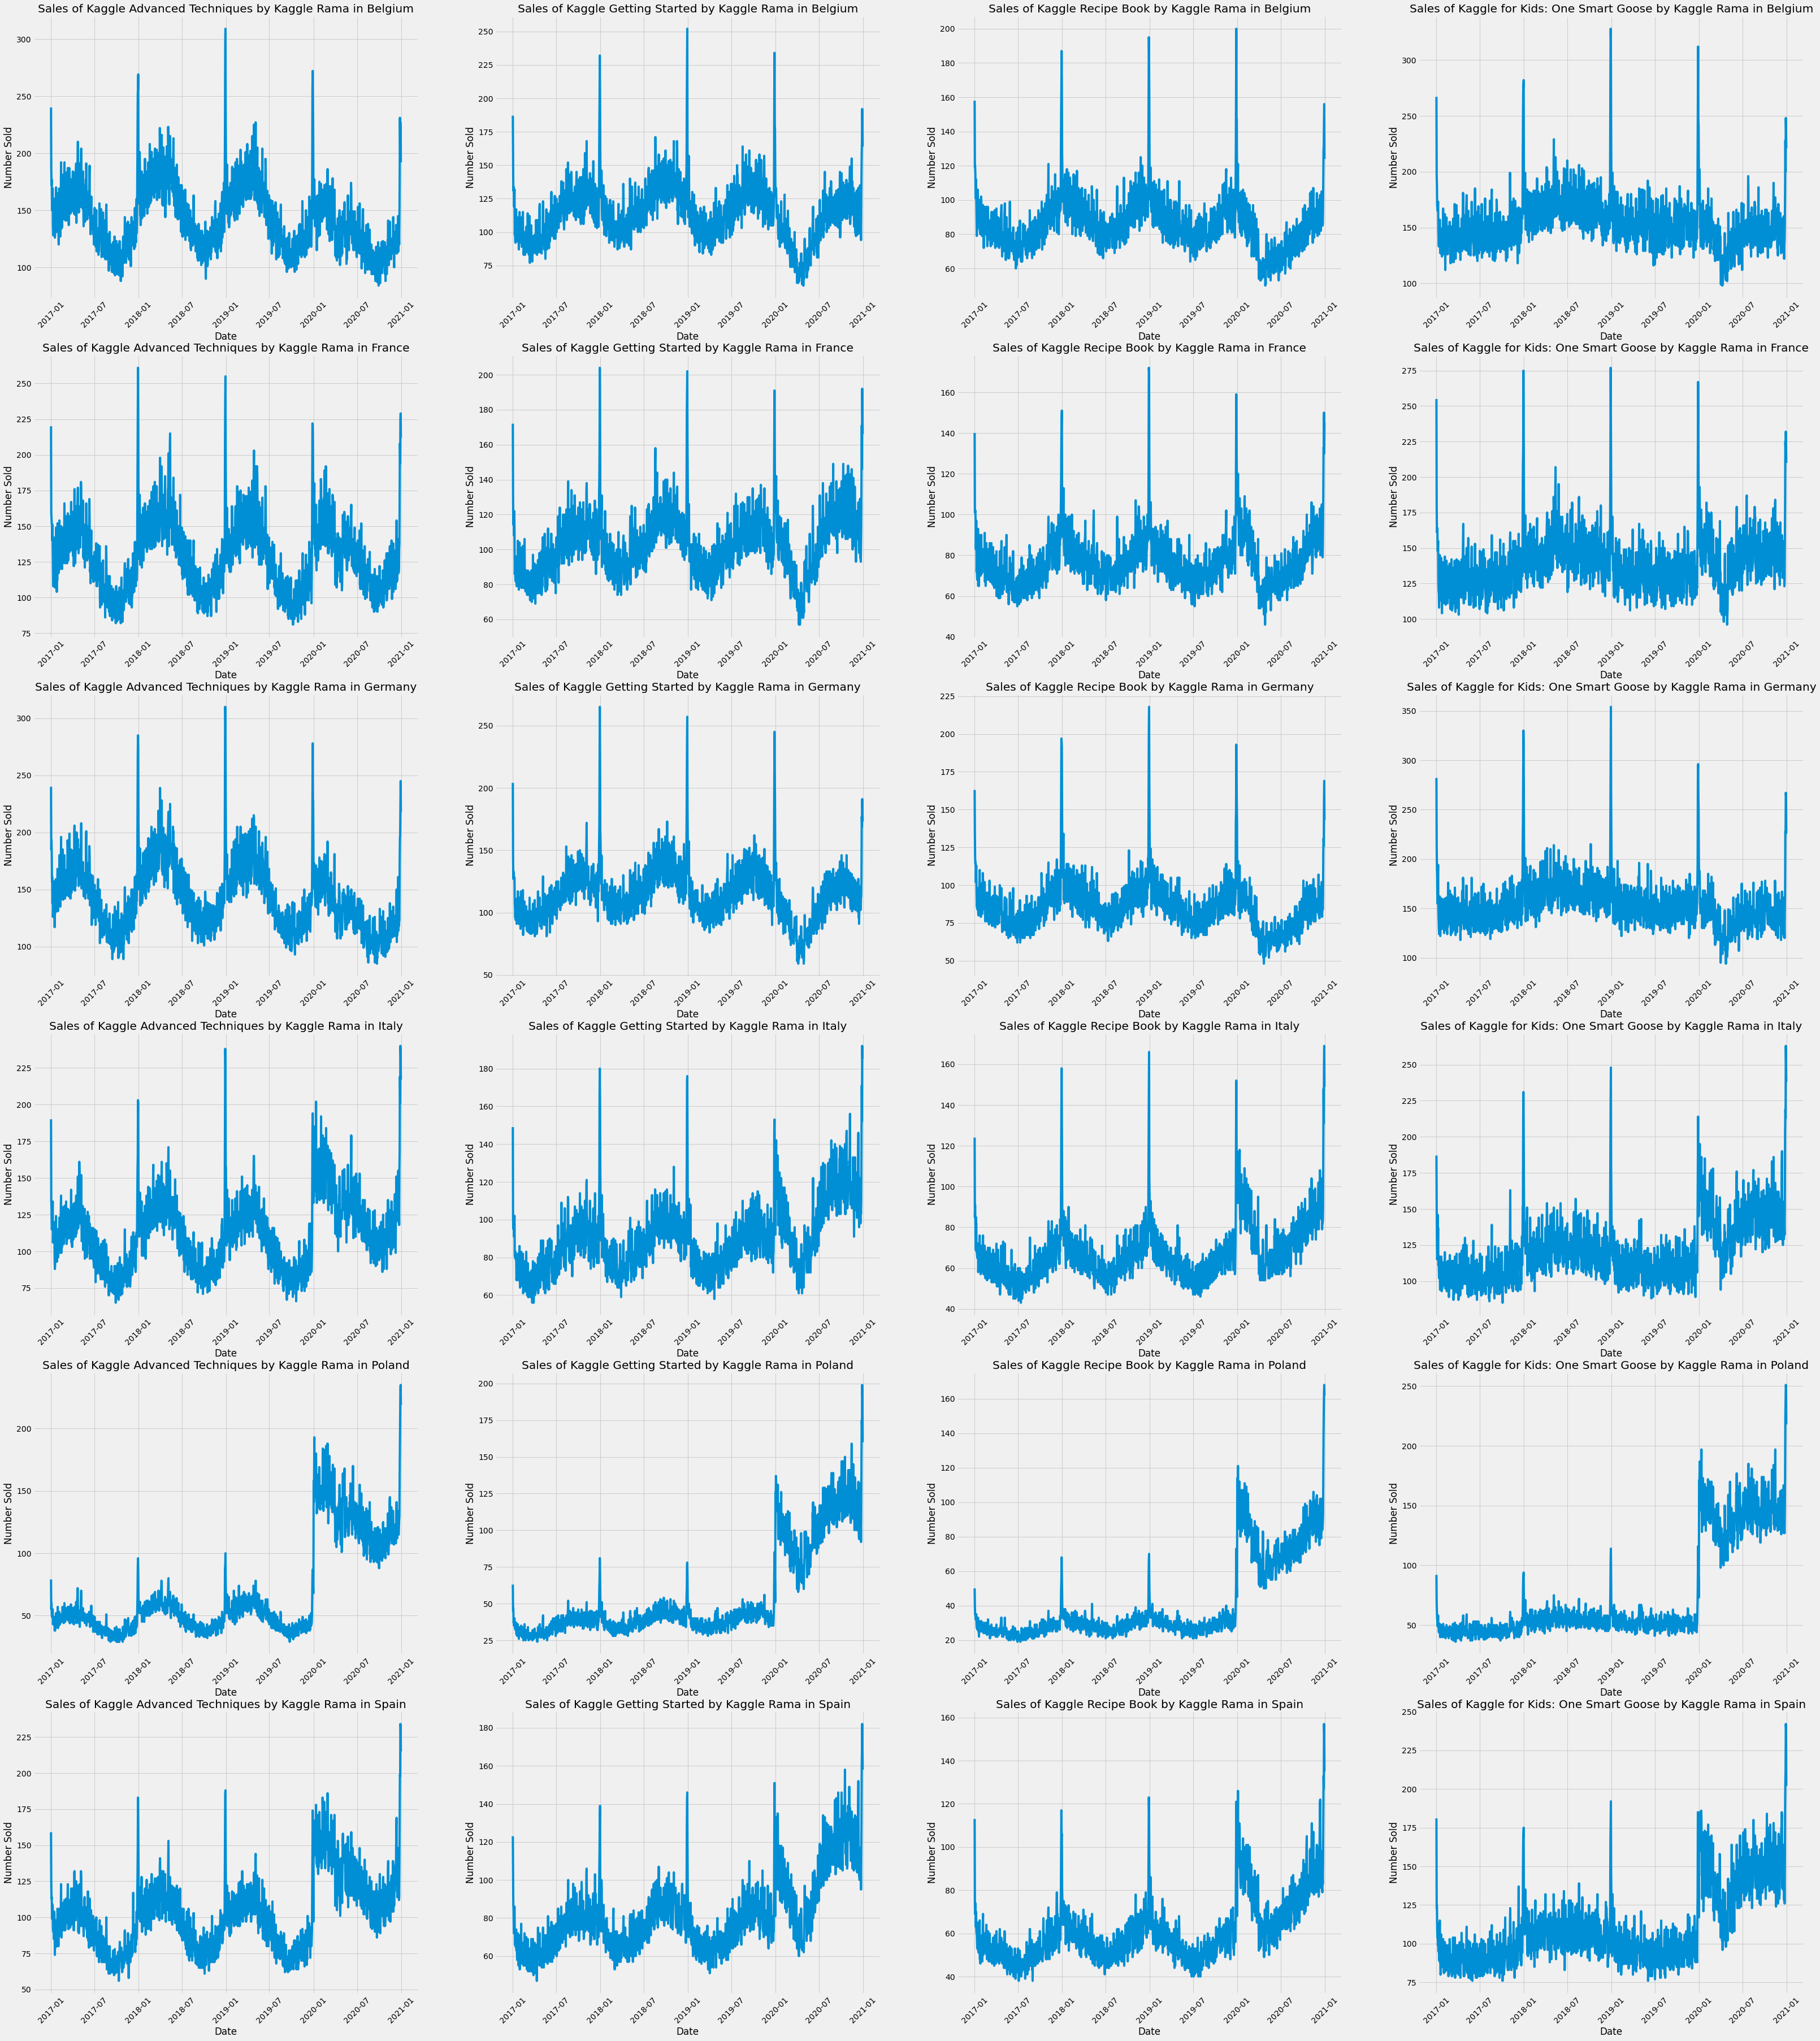

In [8]:
plt.figure(figsize=(50,60))

i = 1

#Plotting Data for KaggleRama
for country in countries:
    for product in products:
        subset_of_sales = sales[(sales['store'] == 'KaggleRama') 
                                & (sales['country'] == country)
                                & (sales['product'] == product)]
        plt.subplot(6, 4, i)
        dates = subset_of_sales['date']
        num_sold = subset_of_sales['num_sold']
        plt.plot(dates, num_sold)
        plt.xticks(rotation=45)
        plt.title('Sales of {p} by Kaggle Rama in {c}'.format(p=product, c=country))
        plt.xlabel('Date')
        plt.ylabel('Number Sold')
        i += 1
            
plt.show()

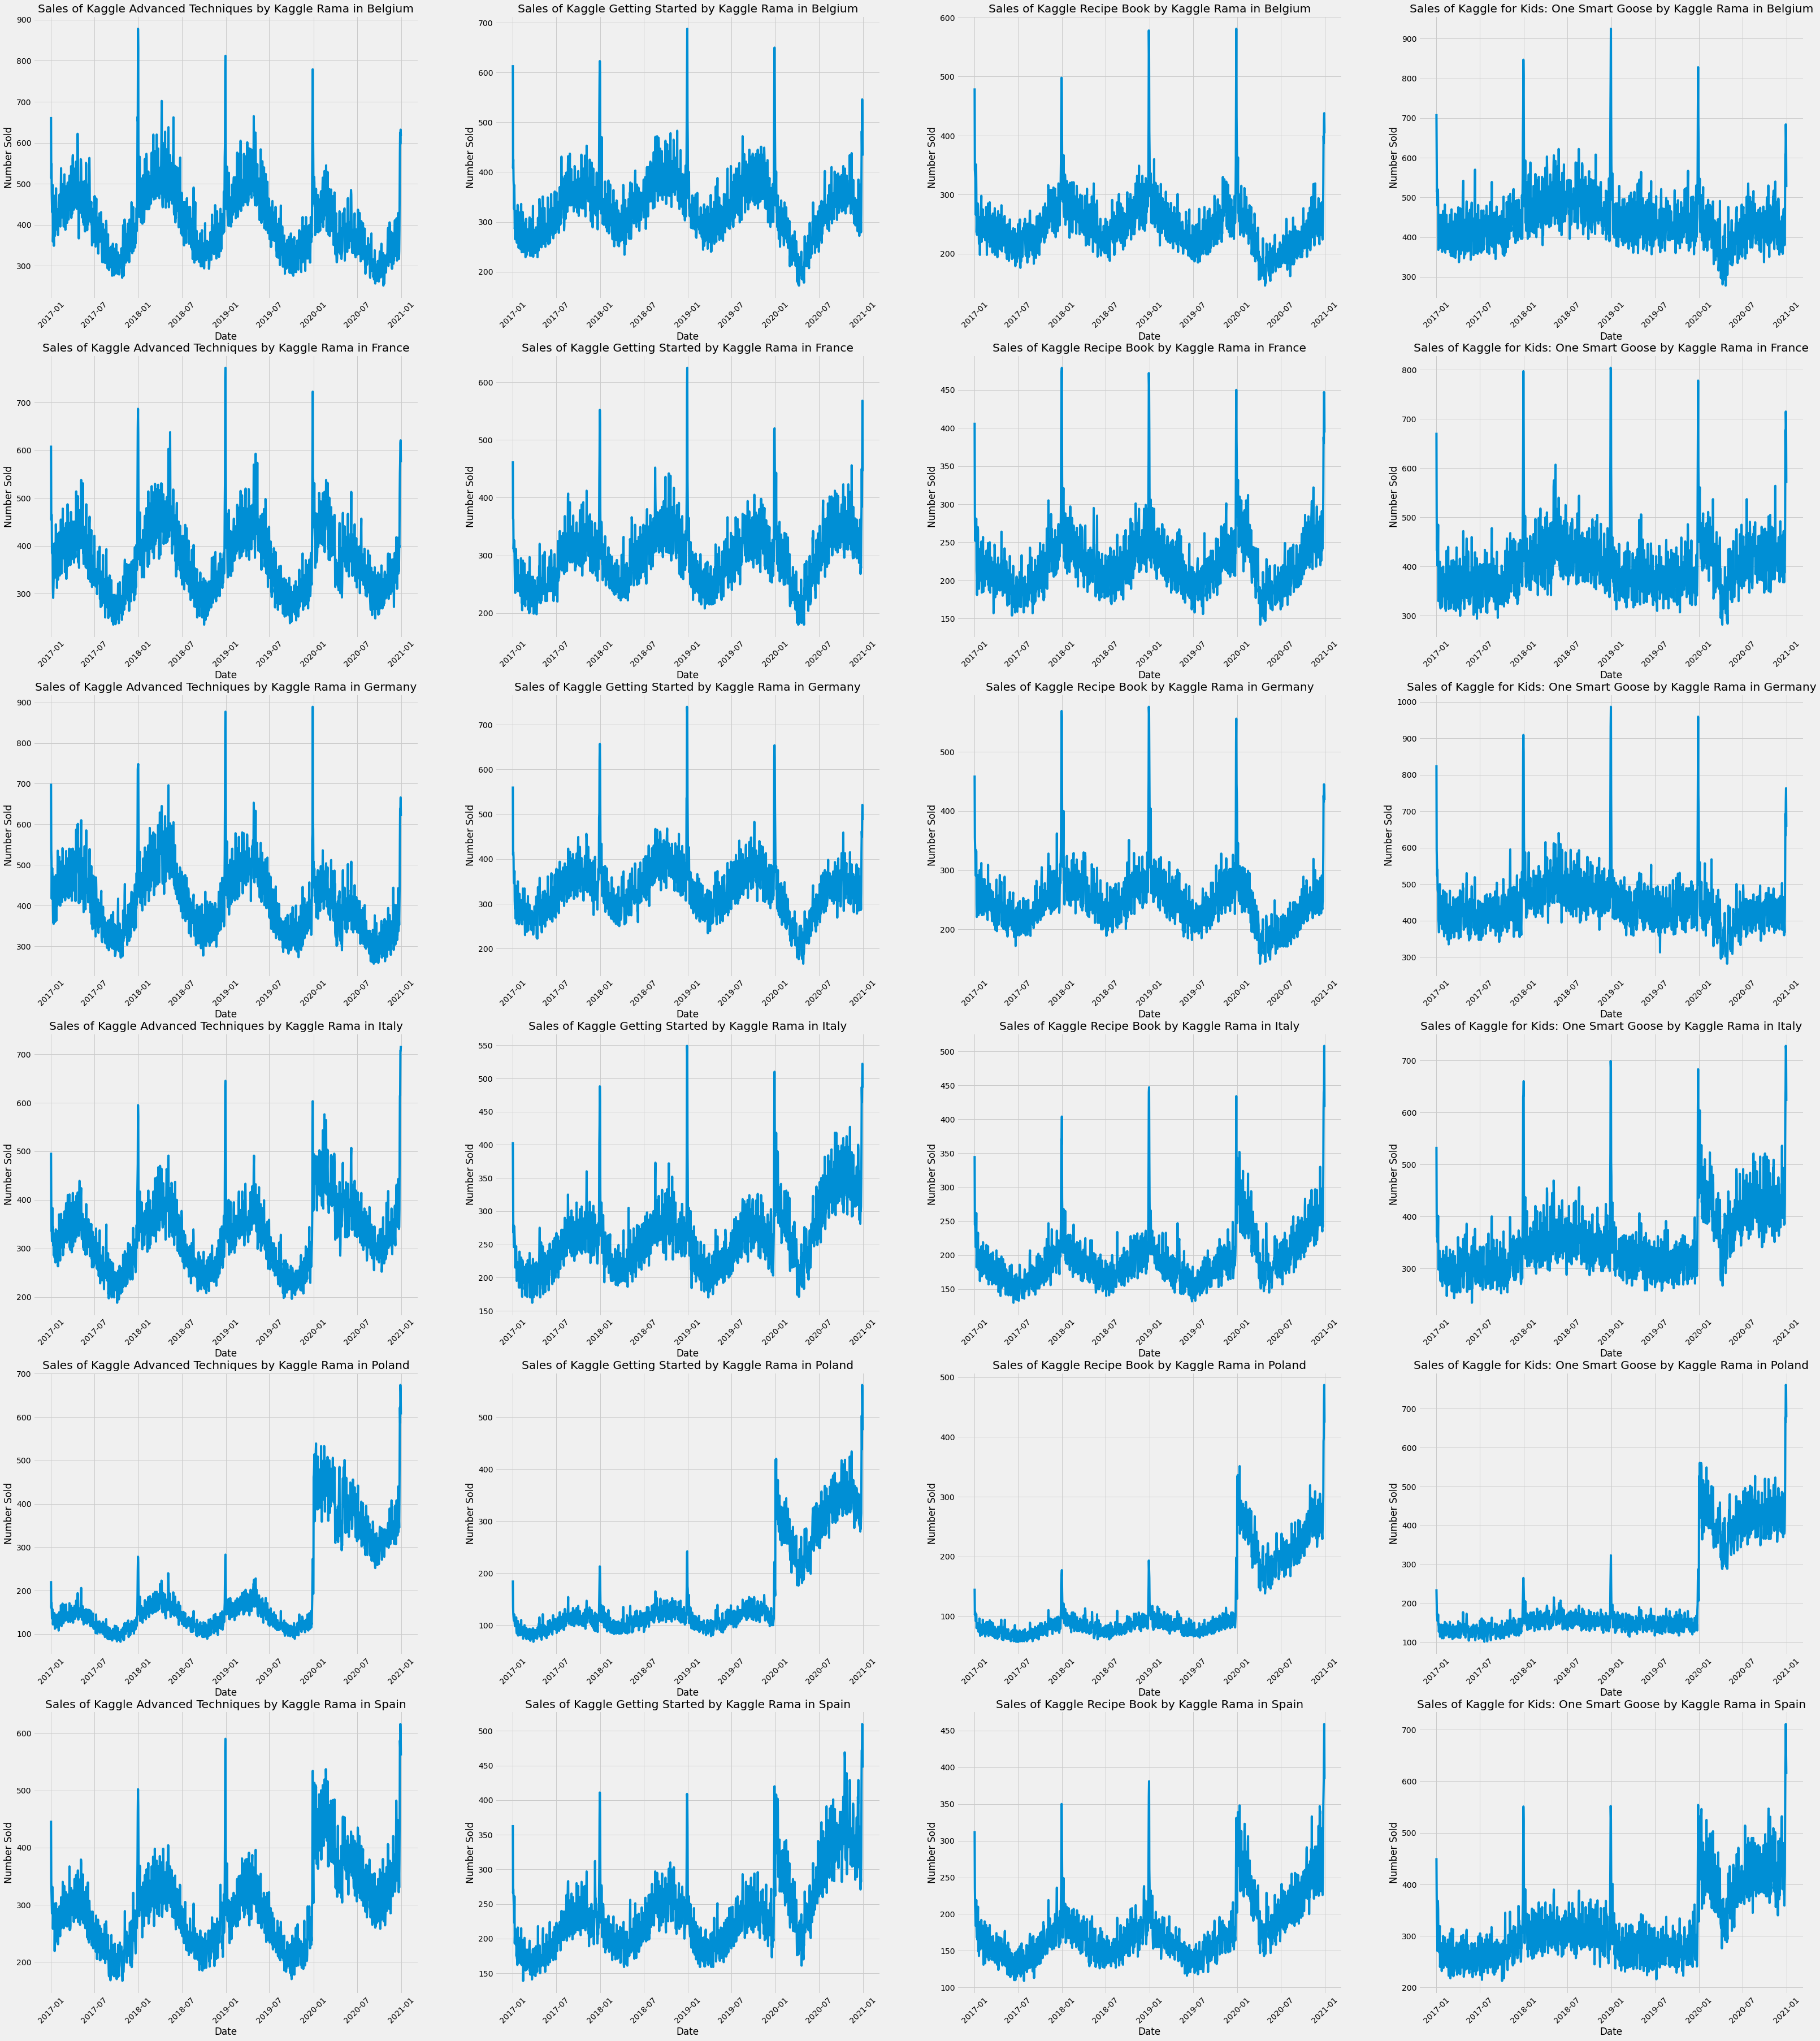

In [9]:
plt.figure(figsize=(50,60))

i = 1

#Plotting Data for KaggleMart
for country in countries:
    for product in products:
        subset_of_sales = sales[(sales['store'] == 'KaggleMart') 
                                & (sales['country'] == country)
                                & (sales['product'] == product)]
        plt.subplot(6, 4, i)
        dates = subset_of_sales['date']
        num_sold = subset_of_sales['num_sold']
        plt.plot(dates, num_sold)
        plt.xticks(rotation=45)
        plt.title('Sales of {p} by Kaggle Rama in {c}'.format(p=product, c=country))
        plt.xlabel('Date')
        plt.ylabel('Number Sold')
        i += 1
            
plt.show()

There are a few points of interest.

First, from the line plots above, we can see that there are seasonal and cyclic patterns to the data, particularly from the years 2017 - 2020. Without using time-series forecasting, we will attempt to model the seasonal patterns by framing it as a supervised learning problem, and encoding the dates as categorical factors (e.g. day of the week, month, quarter) in this project.

Second, we note that there is a rather abrupt change in the data from 2021 onwards for Poland and Spain, which suggests that there might be an exogenous shock that has changed the underlying distribution of the data. We will use the data from 2021 onwards as our hold-out set and tune the learning parameters to reduce variance and prevent overfitting.

Finally, we also note that the patterns differ significantly based on the country, but appear more similarly across stores and products. In the real-world context, this would make sense for time series data on sales if the product is undifferentiated across the stores, and if the products within each store are relatively similar. Then demand for the product will likely fluctuate more based on demographic and seasonal factors which are unique to each country. 

### 2) Labelling and Organizing Data ###

We'll now create categorical variables based on the date of transactions that will help us address the seasonality in the data.

In [10]:
#Create Time series features
def create_time_series_features(df):
    """
    Creates time series features from datetime index
    """
    ord_enc = OrdinalEncoder()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df[['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']] = \
    ord_enc.fit_transform(df[['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']])
    return df

In [11]:
sales = create_time_series_features(sales)

We'll also use one-hot encoding on the store, country and product columns.

In [12]:
#Use one-hot encoding 

#Create dummy columns for each unique value in store, country and product columns
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

sales = create_dummies(sales,"country")
sales = create_dummies(sales,"store")
sales = create_dummies(sales,"product")

In [13]:
#Check that dummy columns have been created
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   date                                      70128 non-null  datetime64[ns]
 1   country                                   70128 non-null  object        
 2   store                                     70128 non-null  object        
 3   product                                   70128 non-null  object        
 4   num_sold                                  70128 non-null  int64         
 5   dayofweek                                 70128 non-null  float64       
 6   quarter                                   70128 non-null  float64       
 7   month                                     70128 non-null  float64       
 8   year                                      70128 non-null  float64       
 9   dayofyear                   

We'll also cut off the data after 2020 to use as our holdout set, and keep only the relevant categorical variables we've created in training our models.

In [14]:
#Cut off our data after 2020 to use as our holdout set
split_date = '2020-01-01'
train = sales[sales['date'] < split_date]
cv = sales.loc[sales['date'] >= split_date]
#Select relevant columns in our dataset
X_train = train.iloc[:,6:24]
y_train = train['num_sold']
X_test = cv.iloc[:,6:24]
y_test = cv['num_sold']

Let's do a quick check to see if our training and holdout sets are what we expect them to be.

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607., 737791.]),
 <a list of 9 Text major ticklabel objects>)

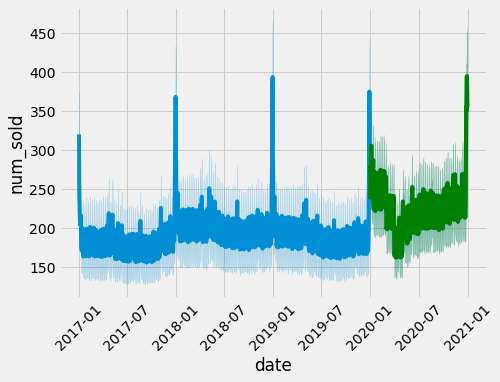

In [15]:
fig = plt.figure(figsize=(15,5)) 
ax1=plt.subplot(121)

sns.lineplot(x="date", y="num_sold", data=sales, ax=ax1) # plot normal time series plot
#ax1.xaxis.set_major_formatter(dates.DateFormatter("%b-%Y")) # change to nicer date format

# plot subset on top of the normal time series
sns.lineplot(x="date", y="num_sold", 
    data=sales[(sales['date'] >= '2020-01-01')], 
    color='green', ax=ax1)

plt.xticks(rotation=45)

The data highlighted in green belong to our holdout set.

In [16]:
print("The first five rows of our training set features are:")
print('\n')
X_train.head()

The first five rows of our training set features are:




,quarter,month,year,dayofyear,dayofmonth,weekofyear,country_Belgium,country_France,country_Germany,country_Italy,country_Poland,country_Spain,store_KaggleMart,store_KaggleRama,product_Kaggle Advanced Techniques,product_Kaggle Getting Started,product_Kaggle Recipe Book,product_Kaggle for Kids: One Smart Goose
row_id,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,51.0,1,0,0,0,0,0,1,0,1,0,0,0
1,0.0,0.0,0.0,0.0,0.0,51.0,1,0,0,0,0,0,1,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,51.0,1,0,0,0,0,0,1,0,0,0,1,0
3,0.0,0.0,0.0,0.0,0.0,51.0,1,0,0,0,0,0,1,0,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,51.0,1,0,0,0,0,0,0,1,1,0,0,0


In [17]:
print("The first five values of our training set labels are:")
print('\n')
y_train.head()

The first five values of our training set labels are:




row_id
0    663
1    615
2    480
3    710
4    240
Name: num_sold, dtype: int64

In [18]:
print("The first five rows of the training features for our holdout set are:")
print('\n')
X_test.head()

The first five rows of the training features for our holdout set are:




,quarter,month,year,dayofyear,dayofmonth,weekofyear,country_Belgium,country_France,country_Germany,country_Italy,country_Poland,country_Spain,store_KaggleMart,store_KaggleRama,product_Kaggle Advanced Techniques,product_Kaggle Getting Started,product_Kaggle Recipe Book,product_Kaggle for Kids: One Smart Goose
row_id,,,,,,,,,,,,,,,,,,
52560,0.0,0.0,3.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,1,0,0,0
52561,0.0,0.0,3.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,1,0,0
52562,0.0,0.0,3.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1,0
52563,0.0,0.0,3.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,1
52564,0.0,0.0,3.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,1,0,0,0


In [19]:
print("The first five values of our holdout set labels are:")
print('\n')
y_test.head()

The first five values of our holdout set labels are:




row_id
52560    501
52561    404
52562    362
52563    536
52564    174
Name: num_sold, dtype: int64

### 3) Defining a Baseline ###

We'll define a baseline level of performance using linear regression without any finetuning. 

We have a few choices of the evaluation metric, such as the mean absolute error (MAE), mean squared error (MSE) or root mean squared error (RMSE).

Since RMSE has the same units as the dependent variable (i.e. y), we will use the RMSE here so that we can evaluate the performance of the model against other models.

In [20]:
#Instantiate a linear regression model
lr = LinearRegression()
#Fit the model
lr.fit(X_train, y_train)
#Predict the labels using the training data
test_predictions = lr.predict(X_test)
#Compute RMSE
baseline_rmse = np.sqrt(mean_squared_error(test_predictions, y_test))
print(baseline_rmse)

82.51976816183473


### 4) Training Model ###

Before we begin, let's create a simple timer function so we know the runtimes for modelling subsequently.

In [21]:
#Simple Timer Function 
def timer(start_time=None):
    if not start_time:
        start_time = dt.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((dt.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

We'll first select our initial hyperparameters for the model using a simple grid search:

1) learning rate:
- A problem with gradient boosted decision trees is that they are quick to learn and overfit training data.
- One effective way to slow down learning in the gradient boosting model is to use a learning rate, also called shrinkage (or eta in XGBoost documentation).Gradient boosting involves creating and adding trees to the model sequentially.

2) min_child_weight:
- It defines the minimum sum of weights of all observations required in a child.
- It is used to control over-fitting.
- Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree
- The larger min_child_weight is, the more conservative the algorithm will be.

3) gamma: 
- A node is split only when the resulting split gives a positive reduction in the loss function.
- Gamma specifies the minimum loss reduction required to make a split.
- It makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
- The larger gamma is, the more conservative the algorithm will be.

4) subsample:
- It denotes the fraction of observations to be randomly sampled for each tree.
- Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. 
- This will prevent overfitting.
- Subsampling will occur once in every boosting iteration.
- Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

5) colsample_bytree:
- colsample_bytree is the subsample ratio of columns when constructing each tree. 
- Subsampling occurs once for every tree constructed.

6) max-depth:
- The maximum depth of a tree.
- It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
- Increasing this value will make the model more complex and more likely to overfit.
- We should be careful when setting large value of max_depth because XGBoost aggressively consumes memory when training a deep tree.

In [22]:
# A parameter grid for XGB
params = {
    'learning_rate': [.01, .03, 0.05, .07],
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}

Below is the code for brute-force grid search.

A total number of combinations for the set of parameters above is a product of options for each parameter (4 x 2 x 3 x 5 x 5 x 3 = 1800). It also needs to be multiplied by 5 to calculate a total number of data-fitting runs as we will be doing 5-fold cross-validation. 

As we are searching across a relatively large number of parameters for the processing power we have, a **brute-force grid search would take a long time.** For this project, we will save time and do a **randomized grid search** instead.

In [23]:
# Initialize XGB and GridSearch
# xgb = xgb.XGBRegressor()
#grid = GridSearchCV(xgb_reg, params, scoring='rmse')
#grid.fit(X_train, y_train)

# print('\n All results:')
# print(grid.cv_results_)
# print('\n Best estimator:')
# print(grid.best_estimator_)
# print('\n Best score:')
# print(grid.best_score_)
# print('\n Best parameters:')
# print(grid.best_params_)

Code above is for the brute-force grid search, which has been commented out for now. 

In [24]:
# Initialize XGB and RandomSearch

model = xgb.XGBRegressor()

folds = 5
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, 
                                   n_jobs=4, cv=skf.split(X_train,y_train), 
                                   verbose=1, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/admin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  3.8min finished



 Time taken: 0 hours 3 minutes and 46.82 seconds.


In [25]:
#print('\n All results:')
#print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized root mean squared error for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(np.sqrt(random_search.best_score_))
print('\n Best hyperparameters:')
print(random_search.best_params_)
#results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

 Best normalized root mean squared error for 5-fold search with 100 parameter combinations:
0.9796676035424855

 Best hyperparameters:
{'subsample': 0.8, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.07, 'gamma': 0.3, 'colsample_bytree': 1.0}


In [26]:
# evaluate performance
yhat = random_search.best_estimator_.predict(X_test)
score = mean_squared_error(y_test, yhat)
score = np.sqrt(score)
print('RMSE: %.3f' % score)

RMSE: 81.787


### 5) Error Analysis ###

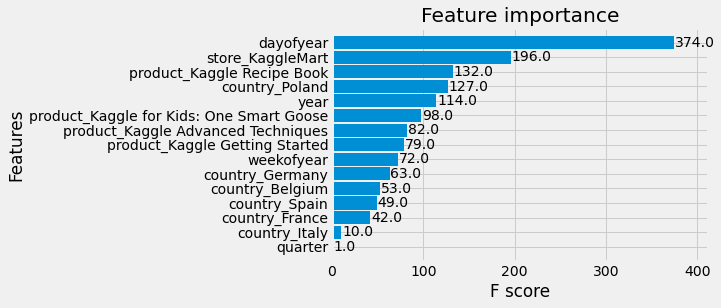

In [27]:
#Feature Importances
_ = plot_importance(random_search.best_estimator_, height=0.9)

This is a metric that simply sums up how many times each feature is split on. We can see that the day of year was most commonly used to split trees. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

Let's plot the learning curves for our model to diagnose the bias-variance trade-off.

In [28]:
def build_XGB(
    _subsample=0.8, 
    _min_child_weight=4, 
    _max_depth=4, 
    _learning_rate=0.07, 
    _gamma=0.3, 
    _colsample_bytree=1.0):
    model = xgb.XGBRegressor(subsample=_subsample, min_child_weight=_min_child_weight, 
                         max_depth=_max_depth, learning_rate=_learning_rate, gamma=_gamma, 
                             colsample_bytree=_colsample_bytree)
    return model

RMSE: 81.787


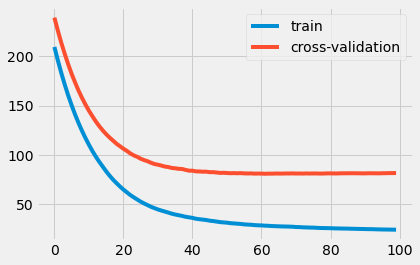

In [29]:
# define the model
model = build_XGB()
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_set=evalset,verbose=False)
# evaluate performance
yhat = model.predict(X_test)
score = np.sqrt(mean_squared_error(yhat, y_test))
print('RMSE: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='cross-validation')
# show the legend
plt.legend()
# show the plot
plt.show()

From the learning curves, we can see that the performance of the model on the training dataset (blue line) is better or has lower loss than the performance of the model on the test dataset (orange line), as we might generally expect.

Looking at the plot, we can see that both curves are flattening out. This suggests that more iterations (adding more trees) would likely not result in any further decrease in loss.

The long flat curves may suggest that the algorithm is learning too fast and we may benefit from slowing it down.

This can be achieved using the learning rate, which limits the contribution of each tree added to the ensemble. This can be controlled via the “eta” hyperparameter and defaults to the value of 0.3. We can try a smaller value, such as 0.05.

Accuracy: 81.320


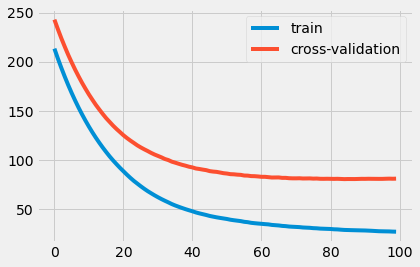

In [30]:
# define the model
model = build_XGB(_learning_rate=0.05)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_set=evalset,verbose=False)
# evaluate performance
yhat = model.predict(X_test)
score = np.sqrt(mean_squared_error(yhat, y_test))
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='cross-validation')
# show the legend
plt.legend()
# show the plot
plt.show()

We see that the our score has improved only marginally to 81.320 from 81.787.

Let's look at the days on which our model performed the worst.

In [33]:
error = yhat - y_test
abs_error = error.apply(np.abs)
abs_error = pd.concat([X_test[['year','month','dayofmonth']], abs_error], axis=1)
error_by_day = abs_error.groupby(['year','month','dayofmonth']) \
    .mean()

In [34]:
# Over forecasted days
error_by_day.rename(columns = {'num_sold':'abs_error'}, inplace=True)
error_by_day.sort_values('abs_error', ascending=False).head(10)

abs_error
year month dayofmonth           
3.0  0.0   4.0         99.933983
           11.0        95.857056
     1.0   15.0        88.456169
     10.0  14.0        88.245178
     1.0   22.0        87.944725
           8.0         87.920410
     11.0  28.0        87.046272
     10.0  7.0         86.940079
     11.0  29.0        86.312859
           12.0        85.987434

Our worst performing days do not correspond to any holidays or sale events that we are aware of, which makes it difficult for us to create an indicator variable for it. 

One possible approach is to remove the outliers which may be skewing our results disproportionately.

### 6) Up Next ? ###

- Add Lag Variables
- Smoothing-Based Models (remove effect of outliers) 
- Apply Time Series Forecasting (e.g. Exponential Smoothing Models like Holt-Winters)